In [98]:
from torchvision import models,transforms,datasets
import torch
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import torch.nn as nn
from torch.autograd import Variable
import torch
import bcolz
import time
import torchvision
from utils import *
from pylab import *
#import tensorflow as tf
#import keras
%matplotlib inline

In [99]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

prep1 = transforms.Compose([
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            normalize,
        ])

In [100]:
data_dir = 'jarmu/'

dsets = {x: datasets.ImageFolder(os.path.join(data_dir, x), prep1)
         for x in ['train', 'val']}

dset_loaders = {x: torch.utils.data.DataLoader(dsets[x], batch_size=8,
                                               shuffle=False, num_workers=4)
                for x in ['train', 'val']}
dset_sizes = {x: len(dsets[x]) for x in ['train', 'val']}
dset_classes = dsets['train'].classes

use_gpu = torch.cuda.is_available()

In [101]:
model_vgg = models.vgg16(pretrained=True)

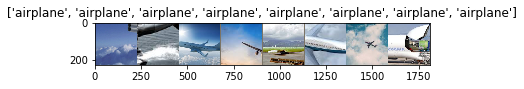

In [102]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dset_loaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[dset_classes[x] for x in classes])

In [103]:
for param in model_vgg.parameters():
    param.requires_grad = False
model_vgg.classifier[6].out_features = 2
for param in model_vgg.classifier[6].parameters():
    param.requires_grad = True

In [104]:
model_vgg = model_vgg.cuda()

In [105]:
def preconvfeat(dataset):
    conv_features = []
    labels_list = []
    for data in dataset:
        inputs,labels = data

        inputs , labels = Variable(inputs.cuda()),Variable(labels.cuda())
        x = model_vgg.features(inputs)
        conv_features.extend(x.data.cpu().numpy())
        labels_list.extend(labels.data.cpu().numpy())
    conv_features = np.concatenate([[feat] for feat in conv_features])
    return (conv_features,labels_list)

In [106]:
%%time
conv_feat_train,labels_train = preconvfeat(dset_loaders['train'])

CPU times: user 5.3 s, sys: 2.34 s, total: 7.64 s
Wall time: 7.74 s


In [107]:
%%time
conv_feat_val,labels_val = preconvfeat(dset_loaders['val'])

CPU times: user 776 ms, sys: 372 ms, total: 1.15 s
Wall time: 1.22 s


In [108]:
save_array('conv_feat_train.bc',conv_feat_train)
save_array('labels_train.bc',labels_train)
save_array('conv_feat_val.bc',conv_feat_val)
save_array('labels_val.bc',labels_val)

In [109]:
conv_feat_train = load_array('conv_feat_train.bc')
labels_train = load_array('labels_train.bc')
conv_feat_val = load_array('conv_feat_val.bc')
labels_val = load_array('labels_val.bc')

In [110]:
conv_feat_train.shape

(316, 512, 7, 7)

In [111]:
criterion = nn.CrossEntropyLoss()
lr = 0.01
optimizer = torch.optim.SGD(model_vgg.classifier[6].parameters(),lr = lr)

In [112]:
def data_gen(conv_feat,labels,batch_size=64,shuffle=True):
    labels = np.array(labels)
    if shuffle:
        index = np.random.permutation(len(conv_feat))
        conv_feat = conv_feat[index]
        labels = labels[index]
    for idx in range(0,len(conv_feat),batch_size):
        yield(conv_feat[idx:idx+batch_size],labels[idx:idx+batch_size])

In [113]:
def train_model(model,size,conv_feat=None,labels=None,epochs=1,optimizer=None,train=True,shuffle=True):
    for epoch in range(epochs):
        batches = data_gen(conv_feat=conv_feat,labels=labels,shuffle=shuffle)
        total = 0
        running_loss = 0.0
        running_corrects = 0
        for inputs,classes in batches:
            inputs , classes = Variable(torch.from_numpy(inputs).cuda()),Variable(torch.from_numpy(classes).cuda())
            inputs = inputs.view(inputs.size(0), -1)
            outputs = model(inputs)
            loss = criterion(outputs,classes)           
            if train:
                if optimizer is None:
                    raise ValueError('Pass optimizer for train mode')
                optimizer = optimizer
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            _,preds = torch.max(outputs.data,1)
            # statistics
            running_loss += loss.data[0]
            running_corrects += torch.sum(preds == classes.data)
        epoch_loss = running_loss / size
        epoch_acc = running_corrects / size
        print('Loss: {:.4f} Acc: {:.4f}'.format(
                     epoch_loss, epoch_acc))

In [114]:
%%time
(train_model(model=model_vgg.classifier,size=dset_sizes['train'],conv_feat=conv_feat_train,labels=labels_train,
            epochs=10,optimizer=optimizer,train=True,shuffle=True))

Loss: 0.1892 Acc: 0.0000
Loss: 0.0355 Acc: 0.5063
Loss: 0.0097 Acc: 0.8386
Loss: 0.0068 Acc: 0.8671
Loss: 0.0049 Acc: 0.9114
Loss: 0.0037 Acc: 0.9462
Loss: 0.0041 Acc: 0.9209
Loss: 0.0034 Acc: 0.9304
Loss: 0.0032 Acc: 0.9304
Loss: 0.0026 Acc: 0.9462
CPU times: user 608 ms, sys: 196 ms, total: 804 ms
Wall time: 799 ms


In [115]:
train_model(conv_feat=conv_feat_val,labels=labels_val,model=model_vgg.classifier
            ,size=dset_sizes['val'],train=False,shuffle=True)

Loss: 0.0022 Acc: 0.9556


In [116]:
for param in model_vgg.classifier.parameters():
    param.requires_grad = True

In [117]:
criterion = nn.CrossEntropyLoss()
lr = 0.01
optimizer = torch.optim.SGD(model_vgg.classifier.parameters(),lr = lr)

In [118]:
train_model(conv_feat=conv_feat_train,labels=labels_train,model=model_vgg.classifier
            ,size=dset_sizes['train'],epochs=5,optimizer=optimizer,train=True,shuffle=True)

Loss: 0.0027 Acc: 0.9494
Loss: 0.0015 Acc: 0.9810
Loss: 0.0014 Acc: 0.9778
Loss: 0.0014 Acc: 0.9652
Loss: 0.0011 Acc: 0.9778


In [119]:
def update_lr_by(value=0.1,optimizer=None):
    if optimizer is None:
        raise ValueError('Pass in a valid optimizer')
    optimizer = optimizer
    for param_group in optimizer.param_groups:
        param_group['lr'] = param_group['lr'] * 0.1
        print('updated learning rate to {}'.format(param_group['lr']))
    return optimizer

In [120]:
optimizer = update_lr_by(optimizer=optimizer)

updated learning rate to 0.001


In [121]:
train_model(conv_feat=conv_feat_train,labels=labels_train,model=model_vgg.classifier
            ,size=dset_sizes['train'],epochs=5,optimizer=optimizer,train=True,shuffle=True)

Loss: 0.0006 Acc: 0.9968
Loss: 0.0008 Acc: 0.9905
Loss: 0.0009 Acc: 0.9842
Loss: 0.0008 Acc: 0.9937
Loss: 0.0007 Acc: 0.9905


In [122]:
model_vgg.classifier[5].p = 0.2
model_vgg.classifier[2].p = 0.2

In [123]:
train_model(conv_feat=conv_feat_train,labels=labels_train,model=model_vgg.classifier
            ,size=dset_sizes['train'],epochs=5,optimizer=optimizer,train=True,shuffle=True)

Loss: 0.0005 Acc: 0.9968
Loss: 0.0004 Acc: 1.0000
Loss: 0.0004 Acc: 1.0000
Loss: 0.0004 Acc: 1.0000
Loss: 0.0003 Acc: 1.0000


In [124]:
models_vgg_bn = models.vgg16_bn()
models_vgg_bn = models_vgg_bn.cuda()

In [125]:
criterion = nn.CrossEntropyLoss()
lr = 0.001
optimizer = torch.optim.SGD(models_vgg_bn.classifier.parameters(),lr = lr)

In [126]:
train_model(conv_feat=conv_feat_train,labels=labels_train,model=models_vgg_bn.classifier
            ,size=dset_sizes['train'],epochs=50,optimizer=optimizer,train=True,shuffle=True)

Loss: 0.1019 Acc: 0.0538
Loss: 0.0684 Acc: 0.4051
Loss: 0.0422 Acc: 0.4304
Loss: 0.0279 Acc: 0.5443
Loss: 0.0224 Acc: 0.5696
Loss: 0.0187 Acc: 0.6329
Loss: 0.0168 Acc: 0.6456
Loss: 0.0157 Acc: 0.6930
Loss: 0.0144 Acc: 0.7215
Loss: 0.0130 Acc: 0.7753
Loss: 0.0121 Acc: 0.7785
Loss: 0.0115 Acc: 0.7722
Loss: 0.0113 Acc: 0.7658
Loss: 0.0105 Acc: 0.8196
Loss: 0.0107 Acc: 0.7975
Loss: 0.0098 Acc: 0.8354
Loss: 0.0091 Acc: 0.8386
Loss: 0.0089 Acc: 0.8513
Loss: 0.0084 Acc: 0.8481
Loss: 0.0075 Acc: 0.8829
Loss: 0.0082 Acc: 0.8576
Loss: 0.0075 Acc: 0.8639
Loss: 0.0072 Acc: 0.9114
Loss: 0.0075 Acc: 0.8861
Loss: 0.0067 Acc: 0.9082
Loss: 0.0066 Acc: 0.8924
Loss: 0.0066 Acc: 0.9272
Loss: 0.0062 Acc: 0.9114
Loss: 0.0058 Acc: 0.9335
Loss: 0.0061 Acc: 0.9146
Loss: 0.0052 Acc: 0.9557
Loss: 0.0057 Acc: 0.8987
Loss: 0.0052 Acc: 0.9335
Loss: 0.0056 Acc: 0.9241
Loss: 0.0055 Acc: 0.9177
Loss: 0.0052 Acc: 0.9209
Loss: 0.0046 Acc: 0.9620
Loss: 0.0048 Acc: 0.9430
Loss: 0.0049 Acc: 0.9304
Loss: 0.0044 Acc: 0.9620


In [127]:
train_model(conv_feat=conv_feat_val,labels=labels_val,model=models_vgg_bn.classifier
            ,size=dset_sizes['val'],train=False,shuffle=False)

Loss: 0.0074 Acc: 0.9333


In [128]:
models_vgg_bn.classifier[5].p = 0.3
models_vgg_bn.classifier[2].p = 0.3

In [129]:
optimizer = update_lr_by(value=0.1,optimizer=optimizer)

updated learning rate to 0.0001


In [130]:
train_model(conv_feat=conv_feat_train,labels=labels_train,model=models_vgg_bn.classifier
            ,size=dset_sizes['train'],epochs=50,optimizer=optimizer,train=True,shuffle=True)

Loss: 0.0030 Acc: 0.9937
Loss: 0.0030 Acc: 0.9873
Loss: 0.0030 Acc: 0.9968
Loss: 0.0031 Acc: 0.9810
Loss: 0.0029 Acc: 0.9873
Loss: 0.0031 Acc: 0.9810
Loss: 0.0030 Acc: 0.9842
Loss: 0.0030 Acc: 0.9810
Loss: 0.0031 Acc: 0.9842
Loss: 0.0030 Acc: 0.9778
Loss: 0.0031 Acc: 0.9810
Loss: 0.0029 Acc: 0.9873
Loss: 0.0029 Acc: 0.9842
Loss: 0.0030 Acc: 0.9873
Loss: 0.0032 Acc: 0.9810
Loss: 0.0031 Acc: 0.9842
Loss: 0.0030 Acc: 0.9905
Loss: 0.0030 Acc: 0.9873
Loss: 0.0028 Acc: 0.9905
Loss: 0.0030 Acc: 0.9810
Loss: 0.0028 Acc: 0.9873
Loss: 0.0028 Acc: 0.9905
Loss: 0.0028 Acc: 0.9873
Loss: 0.0029 Acc: 0.9810
Loss: 0.0028 Acc: 0.9937
Loss: 0.0030 Acc: 0.9842
Loss: 0.0028 Acc: 0.9905
Loss: 0.0029 Acc: 0.9778
Loss: 0.0030 Acc: 0.9810
Loss: 0.0027 Acc: 0.9873
Loss: 0.0029 Acc: 0.9842
Loss: 0.0028 Acc: 0.9873
Loss: 0.0029 Acc: 0.9873
Loss: 0.0029 Acc: 0.9873
Loss: 0.0028 Acc: 0.9810
Loss: 0.0029 Acc: 0.9873
Loss: 0.0028 Acc: 0.9937
Loss: 0.0028 Acc: 0.9905
Loss: 0.0027 Acc: 0.9937
Loss: 0.0028 Acc: 0.9937


In [131]:
train_model(conv_feat=conv_feat_val,labels=labels_val,model=models_vgg_bn.classifier,size=dset_sizes['val'],train=False,shuffle=True)

Loss: 0.0076 Acc: 0.9556


In [132]:
torch.save(models_vgg_bn.state_dict(), '/home/ubuntu/transfer-learning-vgg16/pytorch/a2-weights.pt')

In [133]:
model_vgg = models.vgg16(pretrained=True)
model_vgg = model_vgg.cuda()
for param in model_vgg.features.parameters():
    param.requires_grad = False
    
model_vgg.classifier[6].out_features = 2

criterion = nn.CrossEntropyLoss()
lr = 0.01
optimizer = torch.optim.SGD(model_vgg.classifier.parameters(),lr=lr)

In [134]:
%%time
train=True
for epoch in range(10):
        #batches = data_gen(conv_feat=conv_feat,labels=labels,shuffle=shuffle)
        total = 0
        running_loss = 0.0
        running_corrects = 0
        for inputs,classes in dset_loaders['train']:
            inputs , classes = Variable(inputs.cuda()),Variable(classes.cuda())
            #inputs = inputs.view(inputs.size(0), -1)
            outputs = model_vgg(inputs)
            loss = criterion(outputs,classes)           
            if train:
                if optimizer is None:
                    raise ValueError('Pass optimizer for train mode')
                optimizer = optimizer
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            _,preds = torch.max(outputs.data,1)
            # statistics
            running_loss += loss.data[0]
            running_corrects += torch.sum(preds == classes.data)
        epoch_loss = running_loss / dset_sizes['train']
        epoch_acc = running_corrects / dset_sizes['train']
        print('Loss: {:.4f} Acc: {:.4f}'.format(
                     epoch_loss, epoch_acc))

Loss: 0.2092 Acc: 0.8291
Loss: 0.0298 Acc: 0.9399
Loss: 0.0173 Acc: 0.9684
Loss: 0.0108 Acc: 0.9652
Loss: 0.0107 Acc: 0.9715
Loss: 0.0117 Acc: 0.9525
Loss: 0.0116 Acc: 0.9589
Loss: 0.0152 Acc: 0.9715
Loss: 0.0116 Acc: 0.9684
Loss: 0.0136 Acc: 0.9620
CPU times: user 1min, sys: 27.3 s, total: 1min 28s
Wall time: 1min 29s


In [135]:
def visualize_model(model, num_images=200):
    images_so_far = 0
    fig = plt.figure()

    for i, data in enumerate(dset_loaders['val']):
        inputs, labels = data
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(1, 1, 1)
            #ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('predicted: {}'.format(dset_classes[preds[j]]))
            imshow(inputs.cpu().data[j])

            if images_so_far == num_images:
                return

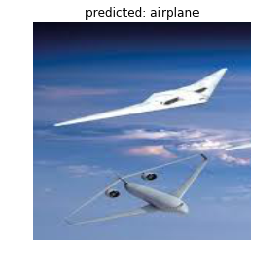

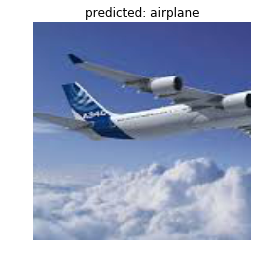

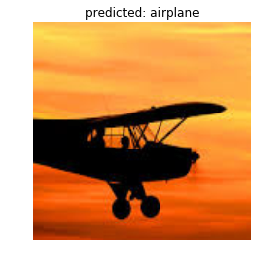

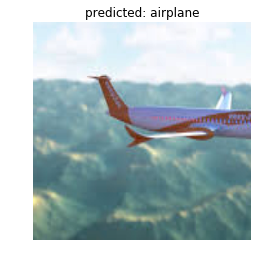

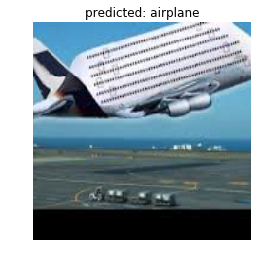

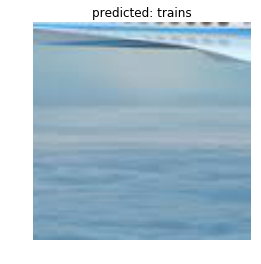

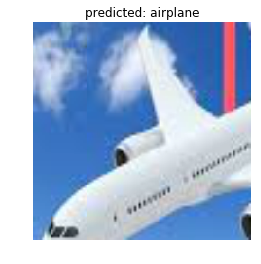

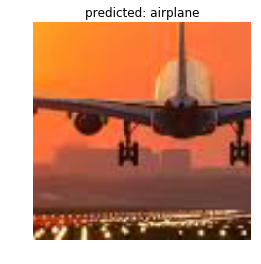

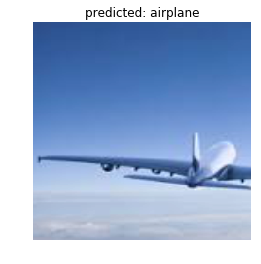

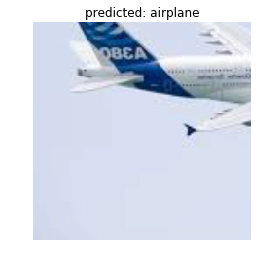

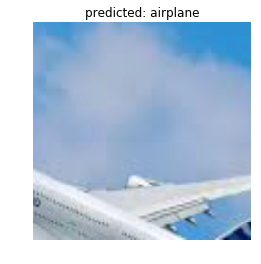

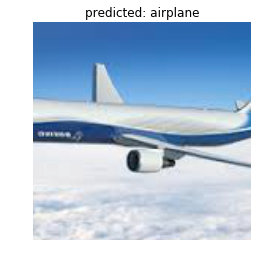

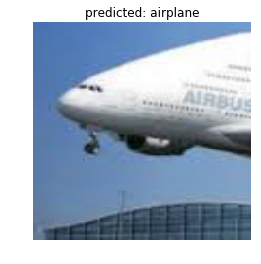

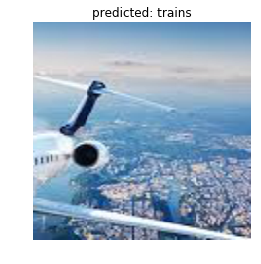

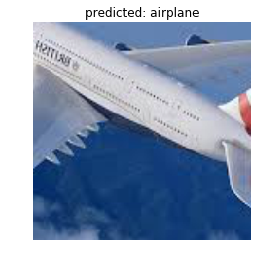

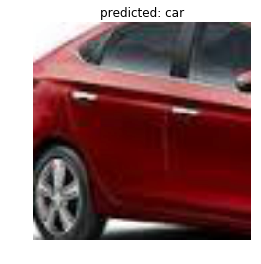

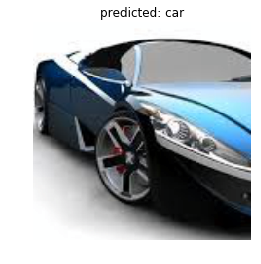

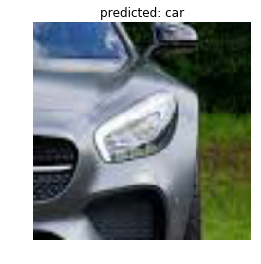

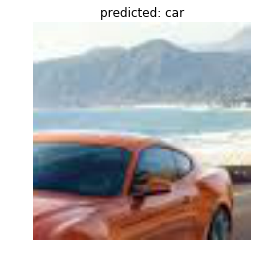

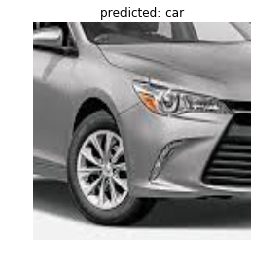

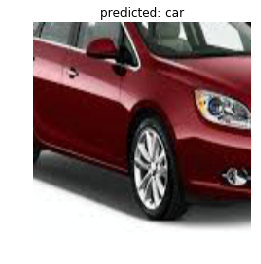

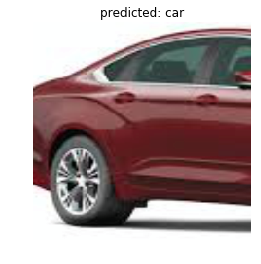

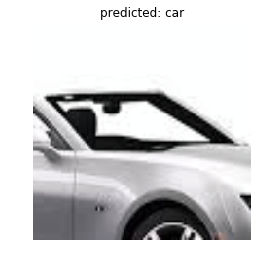

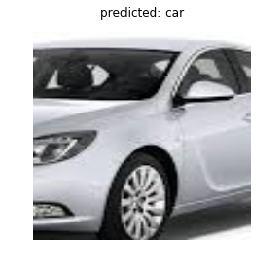

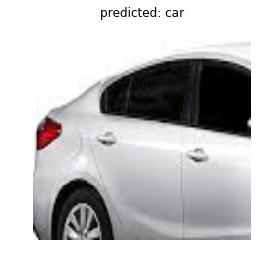

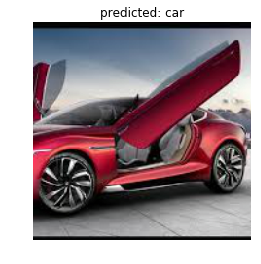

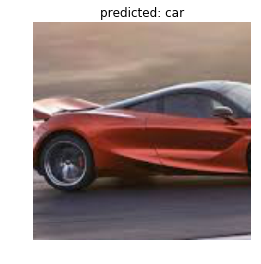

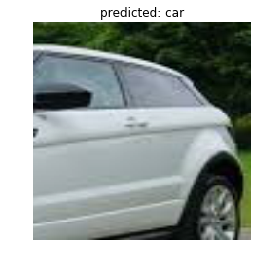

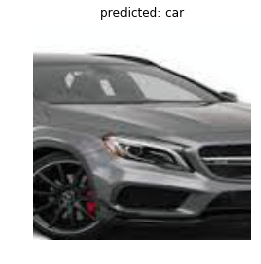

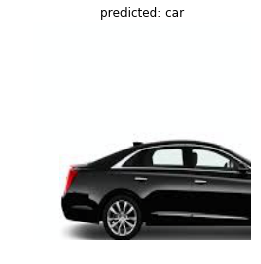

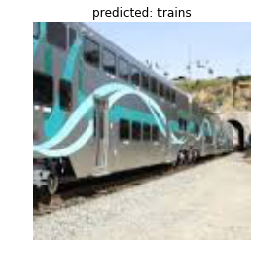

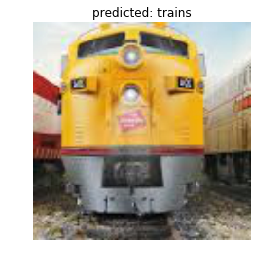

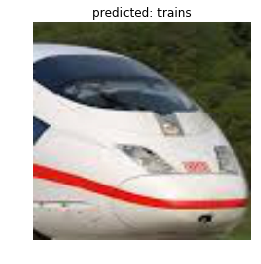

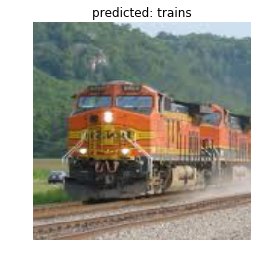

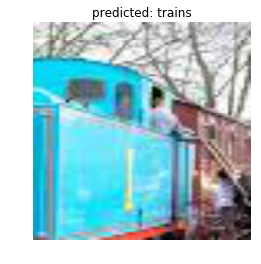

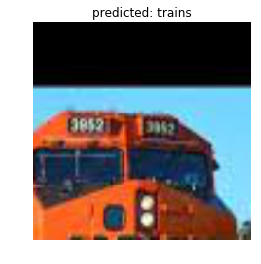

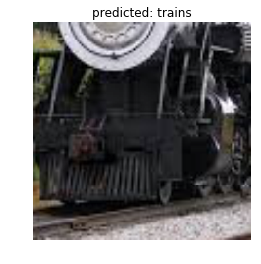

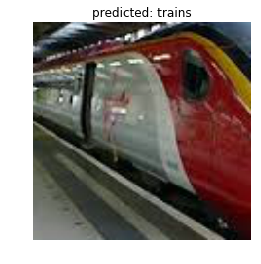

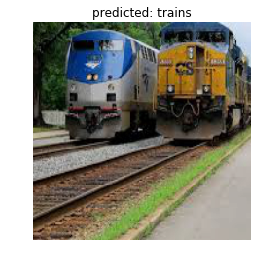

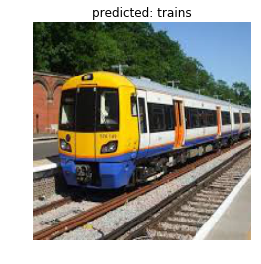

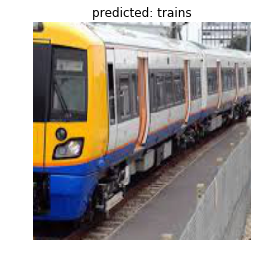

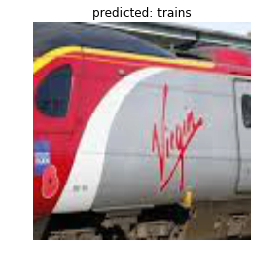

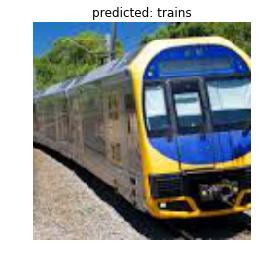

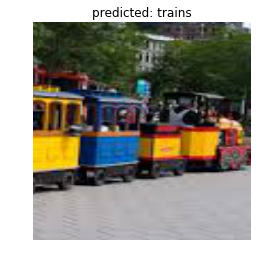

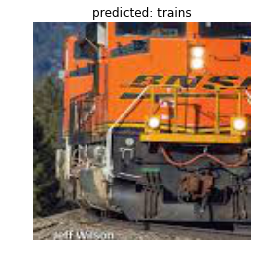

In [136]:
visualize_model(model_vgg)